In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scikit_posthocs as sp


from scipy import stats


from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.decomposition import PCA

from imblearn.under_sampling import EditedNearestNeighbours




In [2]:
df = pd.read_csv("dataset_23_cmc.csv")
df

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure,Contraceptive_method_used
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Wifes_age                     1473 non-null   int64
 1   Wifes_education               1473 non-null   int64
 2   Husbands_education            1473 non-null   int64
 3   Number_of_children_ever_born  1473 non-null   int64
 4   Wifes_religion                1473 non-null   int64
 5   Wifes_now_working%3F          1473 non-null   int64
 6   Husbands_occupation           1473 non-null   int64
 7   Standard-of-living_index      1473 non-null   int64
 8   Media_exposure                1473 non-null   int64
 9   Contraceptive_method_used     1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB


In [4]:
target = "Contraceptive_method_used"

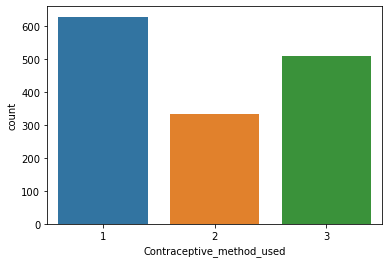

In [5]:
sns.countplot(x = df[target]);


**Normalização entre 0 - 1**

In [6]:
#normlizando 0 - 1
normalized_df = pd.DataFrame()
for i in df.columns:
    if i != target:
        normalized_df[i]=(df[i]-df[i].min())/(df[i].max()-df[i].min())
    else:
        normalized_df[i] = df[i]
        
normalized_df

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure,Contraceptive_method_used
0,0.242424,0.333333,0.666667,0.1875,1.0,1.0,0.333333,0.666667,0.0,1
1,0.878788,0.000000,0.666667,0.6250,1.0,1.0,0.666667,1.000000,0.0,1
2,0.818182,0.333333,0.666667,0.4375,1.0,1.0,0.666667,1.000000,0.0,1
3,0.787879,0.666667,0.333333,0.5625,1.0,1.0,0.666667,0.666667,0.0,1
4,0.606061,0.666667,0.666667,0.5000,1.0,1.0,0.666667,0.333333,0.0,1
...,...,...,...,...,...,...,...,...,...,...
1468,0.515152,1.000000,1.000000,0.1250,1.0,0.0,0.333333,1.000000,0.0,3
1469,0.515152,1.000000,1.000000,0.1875,1.0,1.0,0.000000,1.000000,0.0,3
1470,0.696970,0.666667,0.666667,0.5000,1.0,0.0,0.000000,1.000000,0.0,3
1471,0.515152,0.666667,0.666667,0.2500,1.0,0.0,0.333333,0.333333,0.0,3


**EXPERIMENTO**

In [7]:
def classificador(model,X_train, X_test,y_train, y_test):
    
    
    if type(model).__name__ in ["SVC"] :
        y_t = label_binarize(y_train, classes=[1, 2, 3])
        y_te = label_binarize(y_test, classes=[1, 2,3])
        n_classes = y_t.shape[1]

        classifier = OneVsRestClassifier(model)

        aucs =[]
        y_score = classifier.fit(X_train, y_t).decision_function(X_test)
        for i in range(n_classes):
            fpr, tpr, AUC = roc_curve(y_te[:, i], y_score[:, i])
            aucs.append(auc(fpr,tpr))
            roc = sum(aucs)/3
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)
        roc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

    
    
    new_row = {"ACC":accuracy_score(y_test, model.predict(X_test)),
               "F1":f1_score(y_test, model.predict(X_test), average='weighted'),
                  "AUC":roc}

    matrix_confusao = confusion_matrix(y_test,model.predict(X_test))



    return (new_row, matrix_confusao)

#Mudar para plotar a matriz de confusão média
def plotMatrizConfusao(matriz_list,ax):
    sum = [[0,0,0],[0,0,0],[0,0,0]]
    for i in range(len(matriz_list)):
        sum = sum + matriz_list[i]
        
            
    sns.heatmap(sum/len(matriz_list), annot=True,ax=ax)
    

In [8]:
def otimizadorDeHype(name,X_train,y_train):
    cv = 3
    if name=='knn':
        limite_superior = 100
        limite_inferior = 1 
        limite = list(range(limite_inferior,limite_superior))
        #Parametros a serem escolhidos
        params = {'n_neighbors':limite, 'metric':['euclidean','manhattan']}
        #istanciando 
        gridS = GridSearchCV(KNeighborsClassifier(),params,cv=cv,n_jobs=-1,scoring='accuracy')
        #treinando o grid 
        grid_result = gridS.fit(X_train,y_train)
        return KNeighborsClassifier(metric = grid_result.best_params_['metric'],
                                    n_neighbors = grid_result.best_params_['n_neighbors']  )
    
    if name== 'mlp':
        mlp = MLPClassifier(max_iter=1000)

        params = {
            'hidden_layer_sizes': [(8,8),(316,16),(32,32), (32,64), (64,128)],
            'activation': ['tanh', 'relu'],
            'solver':['sgd','adam'],
            'alpha':[0.0001, 0.05],
            'learning_rate': ['constante','adaptive'],
        }

        gridS = GridSearchCV(mlp,params,n_jobs=-1,cv=cv,scoring='accuracy')
        
        grid_result = gridS.fit(X_train,y_train)
        return MLPClassifier(hidden_layer_sizes=grid_result.best_params_['hidden_layer_sizes'], 
                    activation=grid_result.best_params_['activation'], solver=grid_result.best_params_['solver'],
                    alpha=grid_result.best_params_['alpha'],
                    learning_rate=grid_result.best_params_['learning_rate'], max_iter=100000)
    if name == 'df':
        
        df = DecisionTreeClassifier()
        params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': list(range(2, 10)),
                  'max_depth':list(range(2, 15)),'criterion':["gini", "entropy"]}
        
        gridS = GridSearchCV(df,params,cv=cv,n_jobs=-1,scoring='accuracy')
        
        grid_result = gridS.fit(X_train,y_train)
        return DecisionTreeClassifier(max_leaf_nodes = grid_result.best_params_['max_leaf_nodes'],
                                      min_samples_split=grid_result.best_params_['min_samples_split'] ,
                                     max_depth=  grid_result.best_params_['max_depth'],
                                     criterion = grid_result.best_params_['criterion'])
    if name == "nb":
        
        nb = GaussianNB()
        
        params = {'var_smoothing': np.logspace(0,-9, num=100)}
        
        gridS = GridSearchCV(nb,params,cv=cv,n_jobs=-1,scoring='accuracy')
        
        grid_result = gridS.fit(X_train,y_train)
        return GaussianNB(var_smoothing=grid_result.best_params_['var_smoothing'])
        
        return LogisticRegression(solver='liblinear', penalty=grid_result.best_params_['penalty'])
    if name == "svm":
        
        svm = SVC()
        
        params = {"kernel": ['rbf'], 'C': list(range(1, 100))}
        
        gridS = GridSearchCV(svm ,params,cv=cv,n_jobs=-1,scoring='accuracy')
                                                                                       
        grid_result = gridS.fit(X_train,y_train)
        return SVC(kernel=grid_result.best_params_['kernel'], C=grid_result.best_params_['C'])

In [17]:
def run(X, y, splits_kfold, pre=False, pca=False,ordem= 1):
    kf = StratifiedKFold(n_splits=splits_kfold,random_state=42)
    kf.get_n_splits(X,y)

    metrics = ["ACC","F1","AUC"]


    matriz_knn = []
    matriz_tree = []
    matriz_mlp = []
    matriz_nb = []
    matriz_reg_log = []
    matriz_svm = []

    df_knn = pd.DataFrame(columns=metrics)
    df_tree = pd.DataFrame(columns=metrics)
    df_mlp = pd.DataFrame(columns=metrics)
    df_nb = pd.DataFrame(columns=metrics)
    df_reg_log = pd.DataFrame(columns=metrics)
    df_svm = pd.DataFrame(columns=metrics)



    for train_index, test_index in kf.split(X,y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if ordem == 1:
            
        
            if pre == True:
                resampler = EditedNearestNeighbours(n_neighbors=3, sampling_strategy="auto", kind_sel="mode")
                X_train, y_train = resampler.fit_resample(X_train, y_train)

            if pca == True:
                #PCA com 3 componetnes
                pca = PCA(n_components=3)
                pca.fit(X_train)
                X_train = pca.transform(X_train)
                X_test = pca.transform(X_test)
        
        else:
            
            if pca == True:
                #PCA com 3 componetnes
                pca = PCA(n_components=3)
                pca.fit(X_train)
                X_train = pca.transform(X_train)
                X_test = pca.transform(X_test)
            
            if pre == True:
                resampler = EditedNearestNeighbours(n_neighbors=3, sampling_strategy="auto", kind_sel="mode")
                X_train, y_train = resampler.fit_resample(X_train, y_train)
            


        model = otimizadorDeHype("knn",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_knn = df_knn.append(line, ignore_index=True)
        matriz_knn.append(matrix)



        model = otimizadorDeHype("df",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_tree = df_tree.append(line, ignore_index=True)
        matriz_tree.append(matrix)   



        model = otimizadorDeHype("mlp",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_mlp = df_mlp.append(line, ignore_index=True)
        matriz_mlp.append(matrix)  


        model = otimizadorDeHype("nb",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_nb = df_nb.append(line, ignore_index=True)
        matriz_nb.append(matrix) 
        
        model = otimizadorDeHype("svm",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_svm = df_svm.append(line, ignore_index=True)
        matriz_svm.append(matrix)
        
    return [df_knn,df_tree,df_mlp,df_nb,df_svm ],[matriz_knn,matriz_tree,matriz_mlp,matriz_nb,matriz_svm]

In [18]:
X = normalized_df.drop(target, axis=1).values
y = normalized_df[target].values
splits_kfold = 10

## Treinamento sem Pré Processamento

In [26]:
dataframes,matrizes = run(X,y,splits_kfold)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Treinamento com Pré Processamento ENN

In [25]:
dataframes_pre_enn, matrizes_pre_enn = run(X,y,splits_kfold,True,False)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Treinamento com Pré Processamento PCA

In [24]:
dataframes_pre_pca, matrizes_pre_pca = run(X,y,splits_kfold,True,False)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Experimento com Pré Processamento ENN + PCA

In [23]:
dataframes_pre_enn_pca, matrizes_pre_enn_pca = run(X,y,splits_kfold,True,True)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Experimento com Pré Processamento PCA + ENN

In [19]:
dataframes_pre_pca_enn, matrizes_pre_pca_enn = run(X,y,splits_kfold,True,True,0)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Resultados

In [27]:
def result(dataframes,metrica):
    df_result = pd.DataFrame()
    df_result["KNN"] = dataframes[0][metrica]
    df_result["TREE"] = dataframes[1][metrica]
    df_result["MLP"] = dataframes[2][metrica]
    df_result["NB"] = dataframes[3][metrica]
    df_result["SVM"] = dataframes[4][metrica]
    return df_result

**Acurácia Geral**

In [28]:
print("RESULTADO SEM PRE PROCESSAMENTO")
result(dataframes,"ACC").describe()

RESULTADO SEM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.501066,0.551976,0.560043,0.460310,0.531600
std,0.047610,0.031087,0.029919,0.038887,0.021548
min,0.432432,0.486486,0.517007,0.385135,0.500000
25%,0.460275,0.534692,0.532313,0.433673,0.518707
50%,0.503401,0.557823,0.562695,0.467802,0.534014
75%,0.543126,0.577255,0.582357,0.487279,0.546527
max,0.557823,0.585034,0.598639,0.517007,0.564626


In [29]:
print("RESULTADO COM PRE PROCESSAMENTO ENN")
result(dataframes_pre_enn,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO ENN


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.435195,0.513261,0.506453,0.437213,0.486151
std,0.031720,0.025718,0.020557,0.039104,0.036423
min,0.401361,0.469388,0.472973,0.371622,0.398649
25%,0.413851,0.499138,0.491497,0.422745,0.477891
50%,0.428571,0.511859,0.505079,0.431973,0.488141
75%,0.449945,0.528912,0.520408,0.454082,0.501701
max,0.496599,0.557823,0.537415,0.500000,0.537415


In [30]:
print("RESULTADO COM PRE PROCESSAMENTO PCA")
result(dataframes_pre_pca,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.435195,0.521401,0.520744,0.437213,0.486151
std,0.031720,0.029443,0.022176,0.039104,0.036423
min,0.401361,0.476190,0.486486,0.371622,0.398649
25%,0.413851,0.504240,0.510204,0.422745,0.477891
50%,0.428571,0.515260,0.515260,0.431973,0.488141
75%,0.449945,0.533129,0.532313,0.454082,0.501701
max,0.496599,0.578231,0.564626,0.500000,0.537415


In [31]:
print("RESULTADO COM PRE PROCESSAMENTO ENN+PCA")
result(dataframes_pre_enn_pca,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO ENN+PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.434519,0.496327,0.509211,0.430456,0.489529
std,0.032331,0.046016,0.037934,0.032294,0.027997
min,0.401361,0.385135,0.432432,0.371622,0.432432
25%,0.408784,0.490658,0.497449,0.422745,0.477891
50%,0.428571,0.500000,0.510204,0.430502,0.488141
75%,0.449945,0.517754,0.539920,0.445578,0.501701
max,0.496599,0.564626,0.557823,0.489796,0.537415


In [32]:
print("RESULTADO COM PRE PROCESSAMENTO PCA+ENN")
result(dataframes_pre_pca_enn,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA+ENN


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.431817,0.504491,0.505166,0.429780,0.489529
std,0.035961,0.046213,0.035274,0.032318,0.027997
min,0.378378,0.398649,0.418919,0.371622,0.432432
25%,0.405750,0.494082,0.497449,0.422745,0.477891
50%,0.428571,0.508480,0.513605,0.427124,0.488141
75%,0.449945,0.522109,0.523810,0.445578,0.501701
max,0.496599,0.564626,0.551020,0.489796,0.537415


**F1-Score Geral**

In [33]:
print("RESULTADO SEM PRE PROCESSAMENTO")
result(dataframes,"F1").describe()

RESULTADO SEM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.498426,0.546907,0.552068,0.459060,0.527287
std,0.044993,0.029565,0.032738,0.036814,0.023388
min,0.435822,0.496519,0.505191,0.392321,0.485984
25%,0.459747,0.523381,0.523603,0.436406,0.510397
50%,0.500789,0.549968,0.564801,0.462068,0.532897
75%,0.541319,0.569605,0.579208,0.489088,0.538371
max,0.553529,0.581488,0.586041,0.510943,0.566479


In [34]:
print("RESULTADO COM PRE PROCESSAMENTO")
result(dataframes_pre_enn,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.433228,0.509972,0.504835,0.428022,0.484275
std,0.035710,0.022289,0.019130,0.044441,0.038691
min,0.383220,0.468750,0.480146,0.370103,0.391240
25%,0.410218,0.499924,0.491931,0.396924,0.479619
50%,0.422407,0.509744,0.498343,0.417480,0.483897
75%,0.451581,0.519459,0.522561,0.460327,0.493609
max,0.497185,0.553249,0.532336,0.509781,0.536626


In [35]:
print("RESULTADO COM PRE PROCESSAMENTO PCA")
result(dataframes_pre_pca,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.433228,0.520046,0.519236,0.428022,0.484275
std,0.035710,0.027508,0.024769,0.044441,0.038691
min,0.383220,0.474653,0.478340,0.370103,0.391240
25%,0.410218,0.505095,0.505613,0.396924,0.479619
50%,0.422407,0.517344,0.516861,0.417480,0.483897
75%,0.451581,0.524895,0.530993,0.460327,0.493609
max,0.497185,0.573869,0.566129,0.509781,0.536626


In [36]:
print("RESULTADO COM PRE PROCESSAMENTO ENN+PCA")
result(dataframes_pre_enn_pca,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO ENN+PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.432651,0.495545,0.507077,0.411690,0.488036
std,0.036209,0.047671,0.040772,0.040927,0.029339
min,0.383220,0.378875,0.424832,0.346458,0.428854
25%,0.406353,0.488586,0.493866,0.387463,0.479619
50%,0.422407,0.500597,0.505963,0.407499,0.483897
75%,0.451581,0.518590,0.541169,0.433978,0.493609
max,0.497185,0.562779,0.558344,0.474936,0.536626


In [37]:
print("RESULTADO COM PRE PROCESSAMENTO PCA+ENN")
result(dataframes_pre_pca_enn,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO PCA+ENN


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.429242,0.502982,0.500265,0.411009,0.479797
std,0.040737,0.044703,0.048676,0.042170,0.051219
min,0.367908,0.400337,0.370552,0.339654,0.346458
25%,0.406353,0.495151,0.495198,0.387463,0.479619
50%,0.422407,0.507409,0.512309,0.407499,0.483897
75%,0.451581,0.517119,0.522374,0.433978,0.493609
max,0.497185,0.562779,0.548670,0.474936,0.536626


**AUC**

In [38]:
print("RESULTADO SEM PRE PROCESSAMENTO")
result(dataframes,"AUC").describe()

RESULTADO SEM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.682595,0.708878,0.734449,0.662633,0.699643
std,0.024570,0.025996,0.024063,0.024231,0.019296
min,0.637432,0.669533,0.692873,0.626326,0.671165
25%,0.672371,0.690442,0.722608,0.649094,0.685531
50%,0.687305,0.707762,0.730280,0.658793,0.701053
75%,0.700344,0.728369,0.743953,0.684587,0.715187
max,0.711948,0.754082,0.772036,0.696508,0.724361


In [39]:
print("RESULTADO COM PRE PROCESSAMENTO")
result(dataframes_pre_enn,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.587029,0.690131,0.709951,0.657516,0.686883
std,0.021270,0.025546,0.023502,0.019171,0.031705
min,0.561916,0.656307,0.679869,0.630623,0.635162
25%,0.573220,0.669349,0.696191,0.642836,0.667202
50%,0.584218,0.689667,0.702438,0.662078,0.688836
75%,0.592534,0.704132,0.721601,0.671752,0.698949
max,0.631119,0.737784,0.759936,0.681209,0.745554


In [40]:
print("RESULTADO COM PRE PROCESSAMENTO PCA")
result(dataframes_pre_pca,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.587029,0.693537,0.713641,0.657516,0.686883
std,0.021270,0.021126,0.027117,0.019171,0.031705
min,0.561916,0.666055,0.683700,0.630623,0.635162
25%,0.573220,0.675802,0.696391,0.642836,0.667202
50%,0.584218,0.694170,0.699775,0.662078,0.688836
75%,0.592534,0.702503,0.733056,0.671752,0.698949
max,0.631119,0.732498,0.758102,0.681209,0.745554


In [41]:
print("RESULTADO COM PRE PROCESSAMENTO ENN+PCA")
result(dataframes_pre_enn_pca,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO ENN+PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.585508,0.675581,0.707504,0.653732,0.684041
std,0.023075,0.054573,0.038307,0.019996,0.037584
min,0.554987,0.537431,0.627017,0.630623,0.606748
25%,0.567775,0.664159,0.692192,0.635292,0.667202
50%,0.584218,0.685083,0.711321,0.649773,0.688836
75%,0.592534,0.700782,0.734142,0.671130,0.698949
max,0.631119,0.737784,0.754687,0.681209,0.745554


In [42]:
print("RESULTADO COM PRE PROCESSAMENTO PCA+ENN")
result(dataframes_pre_pca_enn,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA+ENN


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.582662,0.677607,0.702793,0.653532,0.683547
std,0.028399,0.054681,0.039177,0.020238,0.038729
min,0.526525,0.542086,0.618554,0.630623,0.601799
25%,0.567775,0.662424,0.689284,0.634449,0.667202
50%,0.584218,0.688300,0.703161,0.649773,0.688836
75%,0.592534,0.708546,0.726225,0.671130,0.698949
max,0.631119,0.737784,0.754979,0.681209,0.745554


## Matrizes

**KNN Resultados**

Plot das matrizes de confusão

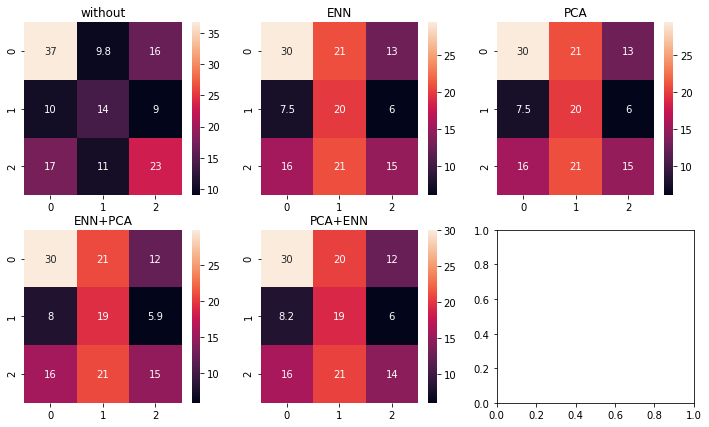

In [43]:
aux = 0
f, axes = plt.subplots(2, 3,figsize=(12,7))
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


**DT Resutaldos**

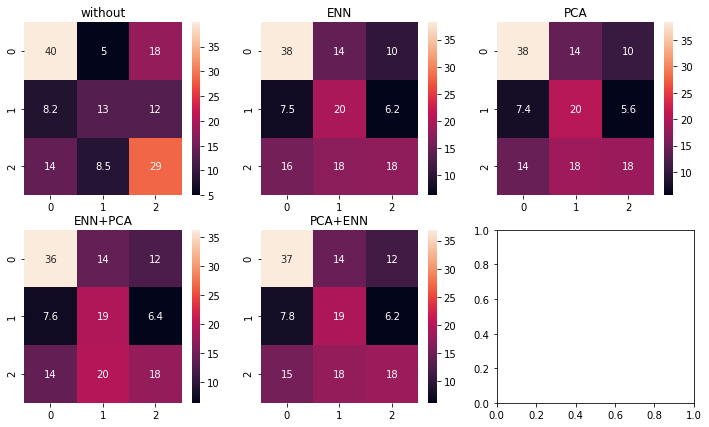

In [44]:
aux = 1
f, axes = plt.subplots(2, 3,figsize=(12,7))
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


**Multilayer Perceptron Resultados**

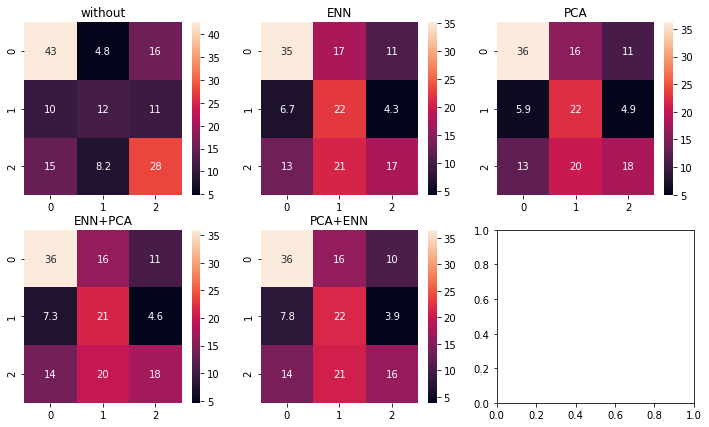

In [45]:
aux = 2
f, axes = plt.subplots(2, 3,figsize=(12,7))
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


**Naive Bayes Resultados**

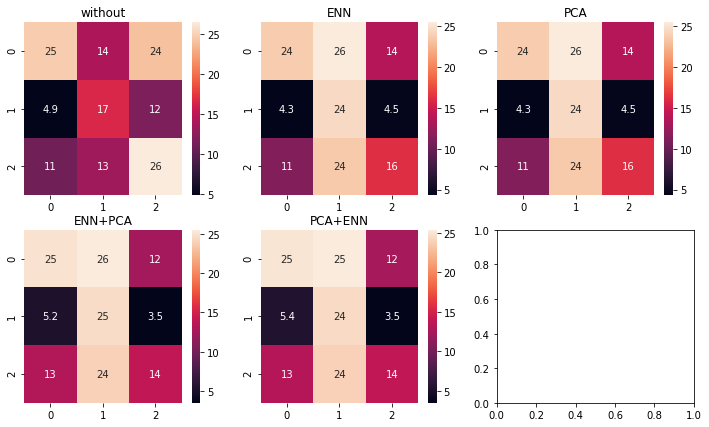

In [46]:
aux = 3
f, axes = plt.subplots(2, 3,figsize=(12,7))
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


**SVM**

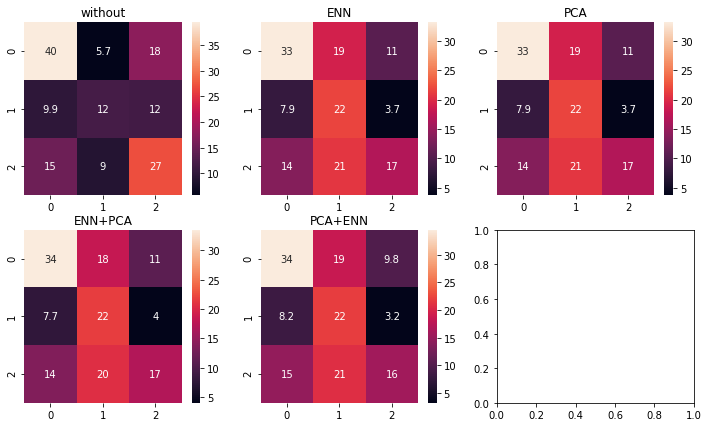

In [48]:
aux = 4
f, axes = plt.subplots(2, 3,figsize=(12,7))
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


## Teste estatisticos

**Shapiro-Wilk**

In [49]:
lista_algoritmos = ["KNN","TREE","MLP","NB","SVM"]
lista_metricas = ["ACC","F1","AUC"] 
p = 0.05
for i, val in enumerate(lista_algoritmos):
    for j in lista_metricas:
        if stats.shapiro(dataframes[i][j])[1] <p:
            print("Normal em "+val+" "+j+" Whitout")
            
        if stats.shapiro(dataframes_pre_enn[i][j])[1] <p:
            print("Normal em "+val+" "+j+" ENN")
        
        if stats.shapiro(dataframes_pre_pca[i][j])[1] <p:
            print("Normal em "+val+" "+j+" PCA")
            
        if stats.shapiro(dataframes_pre_enn_pca[i][j])[1] <p:
            print("Normal em "+val+" "+j+" ENN+PCA")
            
        if stats.shapiro(dataframes_pre_pca_enn[i][j])[1] <p:
            print("Normal em "+val+" "+j+" PCA+ENN")
            
        

Normal em TREE F1 ENN+PCA
Normal em TREE AUC ENN+PCA
Normal em TREE AUC PCA+ENN
Normal em MLP ACC PCA+ENN
Normal em MLP F1 PCA+ENN
Normal em SVM F1 ENN
Normal em SVM F1 PCA
Normal em SVM F1 PCA+ENN


**Teste Estátistico kruskal**

In [50]:
for i, val in enumerate(lista_algoritmos):
    for j in lista_metricas:
        print(j+" "+val)
        
        print(stats.kruskal(dataframes[i][j],dataframes_pre_enn[i][j],  dataframes_pre_pca[i][j],dataframes_pre_enn_pca[i][j],dataframes_pre_pca_enn[i][j])[1])
    print()

ACC KNN
0.0058112070719626855
F1 KNN
0.015337672940981944
AUC KNN
9.257247033435659e-05

ACC TREE
0.015600096405780273
F1 TREE
0.010976995726640579
AUC TREE
0.37515069527453454

ACC MLP
0.003229566527361318
F1 MLP
0.017876763696933546
AUC MLP
0.2584280959466997

ACC NB
0.289765864886661
F1 NB
0.1515312546202885
AUC NB
0.8286549104682172

ACC SVM
0.004413878624321762
F1 SVM
0.011555774361940076
AUC SVM
0.6032670040743754



**Teste Estátistico Dunn's**

In [51]:
for i, val in enumerate(lista_algoritmos):
    for j in lista_metricas:
        print(j+" "+val)
        print("   Whitout     ENN       PCA      ENN+PCA   PCA+ENN")
        lista_aux = [dataframes[i][j],dataframes_pre_enn[i][j],  dataframes_pre_pca[i][j],dataframes_pre_enn_pca[i][j],dataframes_pre_pca_enn[i][j]]
        print(sp.posthoc_dunn(lista_aux))
    print()

ACC KNN
   Whitout     ENN       PCA      ENN+PCA   PCA+ENN
          1         2         3         4         5
1  1.000000  0.003054  0.003054  0.002832  0.001783
2  0.003054  1.000000  1.000000  0.981536  0.871307
3  0.003054  1.000000  1.000000  0.981536  0.871307
4  0.002832  0.981536  0.981536  1.000000  0.889564
5  0.001783  0.871307  0.871307  0.889564  1.000000
F1 KNN
   Whitout     ENN       PCA      ENN+PCA   PCA+ENN
          1         2         3         4         5
1  1.000000  0.006817  0.006817  0.005268  0.004143
2  0.006817  1.000000  1.000000  0.932618  0.871766
3  0.006817  1.000000  1.000000  0.932618  0.871766
4  0.005268  0.932618  0.932618  1.000000  0.938731
5  0.004143  0.871766  0.871766  0.938731  1.000000
AUC KNN
   Whitout     ENN       PCA      ENN+PCA   PCA+ENN
          1         2         3         4         5
1  1.000000  0.000166  0.000166  0.000091  0.000086
2  0.000166  1.000000  1.000000  0.883888  0.871766
3  0.000166  1.000000  1.000000  0.883888